In [181]:
"""File: cassim_inspect.ipynb

Authors: Mattijs Blankesteijn & András Csirik
Computational Dialogue Modelling 2020

This file contains code to inspect CASSIM scores.
"""

'File: cassim_inspect.ipynb\n\nAuthors: Mattijs Blankesteijn & András Csirik\nComputational Dialogue Modelling 2020\n\nThis file contains code to inspect CASSIM scores.\n'

In [182]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from conversations import EmptyAge, Conversation, Person

with open('cassim_pickles.p', 'rb') as f:
        conversations = pickle.load(f)
print(len(conversations), "conversations")
print(len(set([s.id for c in conversations for s in c.speakers])), "speakers")

901 conversations
526 speakers


### Speaker based

In [183]:
class P:
    """Wrapper around Person."""
    
    def __init__(self, person):
        self.person = person
        self.gender = person.gender
        self.age = person.age
        self.age_group = None
        self.id = person.id
        self.aligns_to = []
        self.align_score = []

    def average_align(self):
        return np.nanmean(self.align_score)

    def __repr__(self):
        return self.person.__repr__()

In [184]:
persons = dict()

for c in conversations:
    # Expand Person class with P.
    for person in c.speakers:
        if person.id not in persons:
            persons[person.id] = P(person)

    # Store alignment in P.
    if c.syntax_alignment is not None:
        conv = c.get_conversation()
        for i, (s, _) in enumerate(conv):
            if i:
                aligns_to = conv[i-1][0]
                align_score = c.syntax_alignment[i-1]

                if not np.isnan(align_score) and s in persons:
                    speaker = persons[s]
                    speaker.aligns_to.append(aligns_to)
                    speaker.align_score.append(align_score)
            
            # print(s, conv[i-1][0], c.syntax_alignment[i-1])

In [185]:
# Add age_group to P.
age_groups = {'0-9':   [], '10-19': [], '20-29': [], '30-39': [], '40-49': [],
              '50-59': [], '60-69': [], '70-79': [], '80-89': [], '90-99': []}
for pid, p in persons.items():
    age = p.age 
    if not isinstance(age, EmptyAge):
        if age < 10:
            key = '0-9'
        elif age < 20:
            key = '10-19'
        elif age < 30:
            key = '20-29'
        elif age < 40:
            key = '30-39'
        elif age < 50:
            key = '40-49'
        elif age < 60:
            key = '50-59'
        elif age < 70:
            key = '60-69'
        elif age < 80:
            key = '70-79'
        elif age < 90:
            key = '80-89'
        elif age < 100:
            key = '90-99'
        else:
            print(age)
        p.age_group = key
        age_groups[key].append(p)

age_groups['0-9']

[Person(id=S0654, age=7, gender=F),
 Person(id=S0655, age=9, gender=M),
 Person(id=S0418, age=2, gender=M),
 Person(id=S0621, age=8, gender=F),
 Person(id=S0622, age=8, gender=F),
 Person(id=S0412, age=8, gender=F),
 Person(id=S0191, age=5, gender=M)]

In [186]:
# Create age groups alignments.
d = defaultdict(lambda: defaultdict(list))
for age_group1id, age_group1 in age_groups.items():
    for person in age_group1:
        for i, other_person in enumerate(person.aligns_to):
            if other_person in persons:
                other_group = persons[other_person].age_group
                d[age_group1id][other_group].append(person.align_score[i])

In [187]:

def str_num(num, l=3):
    """convert num to nice string."""
    stnum = str(num)[1:]
    while len(stnum) != l+1:
        stnum += "0"
    return stnum

def dict_to_table(d):
    """Print dict in LaTeX table."""
    cs = 'c ' * (len(d.keys()) + 1)
    print("\\begin{center}")
    print("\\begin{tabular}{"+cs[:-1]+"}")
    [print(' & \\textbf{'+group+"}", end='') for group in d.keys()]
    print(' \\\\')

    for align_group, aligns in d.items():
        target_scores = []
        # for target_group, targets in aligns.items():
        # print(' &')

        for target_group in d.keys():
            targets = aligns[target_group]
            score, std = float('inf'), None
            # print(targets)
            if targets:
                score = round(np.mean(targets), 3)
                std = round(np.std(targets), 2)
            target_scores.append((score, std))

        # print(target_scores)
        scores = ["\\textbf{"+align_group+"}"] + [str_num(score)+f" ({str_num(std, 2)})" if score != float('inf') else '    -     ' for score, std in target_scores]

        for i, score in enumerate(scores):
            end = ' & '
            if i == len(scores) - 1:
                end = ' \\\\\n'
            print(score, end=end)

    print("\\end{tabular}")
    print("\\end{center}")

dict_to_table(d)

\begin{center}
\begin{tabular}{c c c c c c c c c c c}
 & \textbf{0-9} & \textbf{10-19} & \textbf{20-29} & \textbf{30-39} & \textbf{40-49} & \textbf{50-59} & \textbf{60-69} & \textbf{70-79} & \textbf{80-89} & \textbf{90-99} \\
\textbf{0-9} & .599 (.15) & .564 (.16) & .560 (.13) & .556 (.13) & .572 (.16) & .542 (.12) &     -      & .549 (.09) &     -      &     -      \\
\textbf{10-19} & .572 (.16) & .550 (.13) & .543 (.13) & .558 (.14) & .545 (.13) & .543 (.13) & .560 (.13) & .551 (.13) & .517 (.13) &     -      \\
\textbf{20-29} & .578 (.14) & .543 (.13) & .545 (.13) & .545 (.13) & .526 (.13) & .548 (.13) & .547 (.13) & .517 (.13) & .555 (.13) & .542 (.14) \\
\textbf{30-39} & .571 (.13) & .568 (.13) & .545 (.13) & .540 (.13) & .528 (.13) & .536 (.13) & .529 (.13) & .555 (.14) & .510 (.13) & .550 (.13) \\
\textbf{40-49} & .605 (.18) & .546 (.13) & .529 (.13) & .527 (.13) & .528 (.13) & .543 (.13) & .557 (.14) & .533 (.13) & .535 (.14) &     -      \\
\textbf{50-59} & .550 (.13) & .543 (

We have 526 persons in CASSIM data, 404 annotated with age.


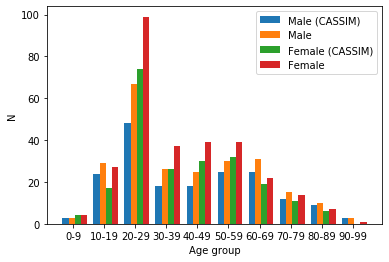

In [188]:
# Some info.
age_n = len([person for a, g in age_groups.items() for person in g])
print(f"We have {len(persons)} persons in CASSIM data, {age_n} annotated with age.")

# Age plot.
groups = [k for k in age_groups.keys()]
values = [a for a in age_groups.values()]
males = [len([p for p in v if p.gender == 'M']) for v in values]
females = [len([p for p in v if p.gender == 'F']) for v in values]

# print(males)
# print(females)

# From another run with all conversations.
males_full = [3, 29, 67, 26, 25, 30, 31, 15, 10, 3]
females_full = [4, 27, 99, 37, 39, 39, 22, 14, 7, 1]

r1 = np.arange(len(groups))
r2 = [r + .2 for r in r1]
r3 = [r + .40 for r in r1]
r4 = [r + .6 for r in r1]

plt.bar(r1, males, label='Male (CASSIM)', width=.2)
plt.bar(r2, males_full, label='Male', width=.2)
plt.bar(r3, females, label='Female (CASSIM)', width=.2)
plt.bar(r4, females_full, label='Female', width=.2)

# plt.bar(groups, values)
plt.ylabel('N')
plt.xlabel('Age group')
plt.xticks([r + .25 for r in range(len(groups))], groups)
# plt.title('Age group & Gender distribution') # we have captions for this
plt.legend()
plt.show()

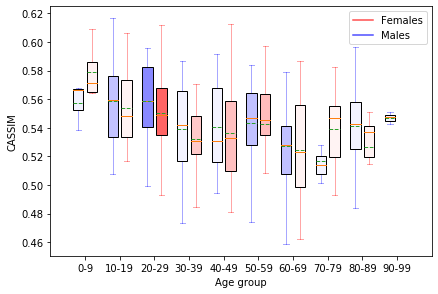

In [189]:
age_males = [[p.average_align() for p in v if p.gender == 'M'] for v in values]
age_females = [[p.average_align() for p in v if p.gender == 'F'] for v in values]

male_alpha = np.array([len(v) for v in age_males])
female_alpha = np.array([len(v) for v in age_females])
male_alpha = male_alpha / sum(male_alpha)
female_alpha = female_alpha / sum(female_alpha)

ticks = groups

# https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
def set_box_color(bp, color, alpha):
    # print(len(bp['boxes']), len(bp['caps']))
    for i, b in enumerate(bp['boxes']):
        # print(i)
        a = alpha[i]
        if a > 0.1:
            a *= 1.8
        else:
            a = (1 - a) * .05
        color[3] = a

        b.set_facecolor(color)    
        bp['caps'][2*i].set_color(color)
        bp['caps'][(2*i)+1].set_color(color)

        color[3] *= 7
        bp['whiskers'][2*i].set_color(color)
        bp['whiskers'][(2*i)+1].set_color(color)

plt.figure()

bpl = plt.boxplot(age_males, positions=np.array(range(len(age_males)))*2.0-0.4, sym='', widths=0.6, patch_artist=True, showmeans=True, meanline=True)
set_box_color(bpl, [0,0,1,0], male_alpha)

bpr = plt.boxplot(age_females, positions=np.array(range(len(age_females)))*2.0+0.4, sym='', widths=0.6, patch_artist=True, showmeans=True, meanline=True)
set_box_color(bpr, [1,0,0,0], female_alpha)

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c=[1,0,0,.7], label='Females')
plt.plot([], c=[0,0,1,.7], label='Males')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.xlabel('Age group')
plt.ylabel('CASSIM')
plt.show()

In [190]:
# Create age groups alignments
males = [p for _, p in persons.items() if p.gender == 'M']
females = [p for _, p in persons.items() if p.gender == 'F']

g = defaultdict(lambda: defaultdict(list))
for _, person in persons.items():
    for i, other in enumerate(person.aligns_to):
        if other in persons:
            g[person.gender][persons[other].gender].append(person.align_score[i])

dict_to_table(g)

\begin{center}
\begin{tabular}{c c c}
 & \textbf{F} & \textbf{M} \\
\textbf{F} & .532 (.13) & .548 (.13) \\
\textbf{M} & .547 (.13) & .537 (.13) \\
\end{tabular}
\end{center}


### Conversation Based

In [191]:
conversations[0]

ConversationClass(id=S4MV-tgd.xml, n_male=0, n_female=2, min_age=36, max_age=36, age_range=0)

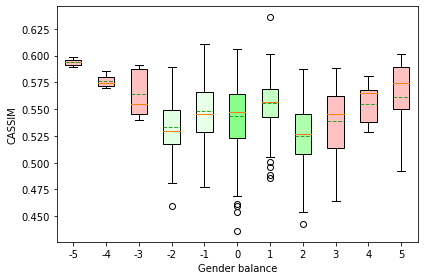

In [192]:
c_g = defaultdict(list)

for c in conversations: 
    alignment = np.nanmean(c.syntax_alignment)
    if not np.isnan(alignment):
        # print(alignment)
        c_g[c.gender].append(alignment)

values = [[] for _ in range(len(c_g.keys()))]
for i, key in enumerate(sorted(c_g.keys())):
    values[i] = c_g[key]

vs_alpha = np.array([len(v) for v in values])
vs_alpha = vs_alpha / sum(vs_alpha)

fig, ax = plt.subplots()
bp_dict = ax.boxplot(values, patch_artist=True, showmeans=True, meanline=True)
for i, b in enumerate(bp_dict['boxes']):
    a = vs_alpha[i]
    if a > 0.04:
        c = [0, 1, 0 , a * 1.3]
    else:
        c = [1, 0, 0, (1 - a) * .25]
    b.set_facecolor(c)

ax.set_xticklabels(sorted(c_g.keys()))
ax.set_ylabel('CASSIM')
ax.set_xlabel('Gender balance')
plt.tight_layout()

plt.show()   